## dcgan pytorch
pytorch tutorial 日本語版のコードをそのまま動かした  
https://colab.research.google.com/github/YutaroOgawa/pytorch_tutorials_jp/blob/main/notebook/2_Image_Video/2_4_dcgan_faces_tutorial_jp.ipynb#scrollTo=CHSEk3sRDXKd

In [1]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# 再現性のためにrandom seedを設定する
manualSeed = 999
#manualSeed = random.randint(1, 10000) # 新たな結果を得たい場合に使用する
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
# データセットのルートディレクトリ
dataroot = "data/celeba"  # 後で、日本語版では修正します
# dataloaderのワーカー数
workers = 2
# 訓練中のバッチサイズ
batch_size = 128
# 訓練画像の高さと幅のサイズ
# 全ての画像は変換器を使ってこのサイズにリサイズされます。
image_size = 64
# 訓練画像のチャンネル数。カラー画像の場合は3。
nc = 3
# 潜在ベクトルzのサイズ (すなわち,、生成器に入力されるベクトルのサイズ)
nz = 100
# 生成器を伝播する特徴マップのサイズ
ngf = 64
# 識別器を伝播する特徴量マップのサイズ
ndf = 64
# 訓練エポック数
num_epochs = 5
# オプティマイザの学習率
lr = 0.0002
# オプティマイザ：Adamのハイパーパラメータ Beta1の値
beta1 = 0.5
#  利用可能なGPUの数。CPUモードの場合は0を使用。
ngpu = 1

In [3]:
cd drive/MyDrive/

/content/drive/MyDrive


In [7]:
cd GDL_pytorch

/content/drive/MyDrive/GDL_pytorch


In [10]:
!unzip  "img_align_celeba.zip" -d "data/"

ストリーミング出力は最後の 5000 行に切り捨てられました。
 extracting: data/img_align_celeba/024631.jpg  
 extracting: data/img_align_celeba/024632.jpg  
 extracting: data/img_align_celeba/024633.jpg  
 extracting: data/img_align_celeba/024634.jpg  
 extracting: data/img_align_celeba/024635.jpg  
 extracting: data/img_align_celeba/024636.jpg  
 extracting: data/img_align_celeba/024637.jpg  
 extracting: data/img_align_celeba/024638.jpg  
 extracting: data/img_align_celeba/024639.jpg  
 extracting: data/img_align_celeba/024640.jpg  
 extracting: data/img_align_celeba/024641.jpg  
 extracting: data/img_align_celeba/024642.jpg  
 extracting: data/img_align_celeba/024643.jpg  
 extracting: data/img_align_celeba/024644.jpg  
 extracting: data/img_align_celeba/024645.jpg  
 extracting: data/img_align_celeba/024646.jpg  
 extracting: data/img_align_celeba/024647.jpg  
 extracting: data/img_align_celeba/024648.jpg  
 extracting: data/img_align_celeba/024649.jpg  
 extracting: data/img_align_celeba/024650.jpg  
 extract

In [13]:
# 最後に切れたファイルを消しておく
# !rm "data/img_align_celeba/029630.jpg"

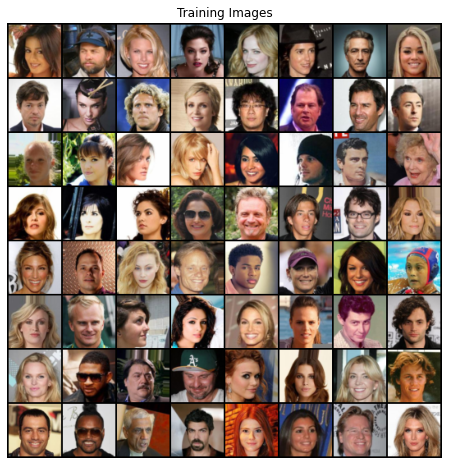

In [14]:
# 画像フォルダのデータセットを設定した方法で使用できます。
# datasetオブジェクトの作成

dataroot = "data/"  # 日本語版の修正に合わせてパスを変更

dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# dataloaderオブジェクトの作成
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, drop_last=True)  # 日本語版drop_last=Trueを追記しています

# どのデバイスで実行するかを決める
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# トレーニング画像をプロット
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [15]:
len(dataset)

29627

In [16]:
# カスタムの重み初期化用関数。netGとnetDで呼び出される
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [17]:
# 生成器コード
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # 入力値はZで、畳み込みが適用されます
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # サイズ：(ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # サイズ：(ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # サイズ：(ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # サイズ：(ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # サイズ： (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [18]:
# 生成器オブジェクトを作成する
netG = Generator(ngpu).to(device)

# 必要に応じてマルチCPUを扱う
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# weights_init関数を適用して、mean=0, stdev=0.2になるようすべての重みをランダムに初期化する
netG.apply(weights_init)

# モデルをprint出力する
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [19]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # 入力は (NC) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # サイズ：(ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # サイズ： (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # サイズ：(ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # サイズ： (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [20]:
# 識別器を作成する
netD = Discriminator(ngpu).to(device)

# 必要に応じてマルチCPUを扱う
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# weights_init関数を適用して、mean=0, stdev=0.2になるようすべての重みをランダムに初期化する
netD.apply(weights_init)

# モデルをprint出力する
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [21]:
# BCELoss関数の初期化
criterion = nn.BCELoss()

# 生成器の訓練の進行状況を可視化するために使用する潜在ベクトルのバッチを作成
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# 訓練中に利用する本物と偽物のラベルを設定
real_label = 1.
fake_label = 0.

# GとDの両方にオプティマイザ：Adamを設定する
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# 訓練のループ

# 訓練の進捗状況を把握するためのリスト
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# 各エポックについて
for epoch in range(num_epochs):
    # dataloader内の各バッチについて
    for i, data in enumerate(dataloader, 0):
        
        ############################
        #  (1) 識別器Dのネットワーク更新: maximize log(D(x)+ log(1 - D(G(z)) )
        ###########################
        ## 本物画像のバッチを使った訓練
        netD.zero_grad()
        # バッチの形式をランタイムに合わせる
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # 本物画像のバッチをDに順伝播させる
        output = netD(real_cpu).view(-1)
        # 全ての本物画像のバッチの損失を計算する
        errD_real = criterion(output, label)
        # 逆伝播で勾配を計算する
        errD_real.backward()
        D_x = output.mean().item()

        ## 偽物画像のバッチを使った訓練
        # 潜在ベクトルのバッチを生成
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Gを使って、偽画像のバッチを生成
        fake = netG(noise)
        label.fill_(fake_label)
        # Dを使って、全ての偽画像を分類
        output = netD(fake.detach()).view(-1)
        # 全ての偽画像に対するDの損失を計算
        errD_fake = criterion(output, label)
        # 偽画像に対する勾配を計算
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # 全ての本物画像のバッチの勾配と、全ての偽画像のバッチの勾配を足す
        errD = errD_real + errD_fake
        # Dのパラメータを更新
        optimizerD.step()

        ############################
        # (2) 生成器Gのネットワークを更新: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # 生成器の損失にとっては、偽画像ラベルが正解になる
        # ちょうど識別器Dを更新したので、偽画像バッチをもう一度識別器Dに順伝播させる
        output = netD(fake).view(-1)
        # この出力に対するGの損失をもう一度計算
        errG = criterion(output, label)
        # Gの勾配を計算
        errG.backward()
        D_G_z2 = output.mean().item()
        # Gを更新
        optimizerG.step()
        
        # 訓練のステータスを出力
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # あとでプロットするために損失を保存
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # 生成器Gの出力をfixed_noiseに保存して、生成器の動作を確認
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/5][0/231]	Loss_D: 0.1950	Loss_G: 8.3018	D(x): 0.9441	D(G(z)): 0.0717 / 0.0005
[0/5][50/231]	Loss_D: 0.6687	Loss_G: 15.2918	D(x): 0.9661	D(G(z)): 0.3784 / 0.0000
[0/5][100/231]	Loss_D: 1.1008	Loss_G: 5.3496	D(x): 0.8704	D(G(z)): 0.4237 / 0.0103
[0/5][150/231]	Loss_D: 0.8516	Loss_G: 5.0936	D(x): 0.5890	D(G(z)): 0.0175 / 0.0157
[0/5][200/231]	Loss_D: 1.4160	Loss_G: 5.4907	D(x): 0.4756	D(G(z)): 0.0006 / 0.0424
[1/5][0/231]	Loss_D: 0.3979	Loss_G: 4.4945	D(x): 0.8889	D(G(z)): 0.2040 / 0.0199
[1/5][50/231]	Loss_D: 0.2793	Loss_G: 3.9592	D(x): 0.8330	D(G(z)): 0.0688 / 0.0338
[1/5][100/231]	Loss_D: 0.6086	Loss_G: 3.0997	D(x): 0.7910	D(G(z)): 0.2208 / 0.0740
[1/5][150/231]	Loss_D: 0.8348	Loss_G: 2.7609	D(x): 0.6134	D(G(z)): 0.0730 / 0.1107
[1/5][200/231]	Loss_D: 0.4167	Loss_G: 4.4573	D(x): 0.7797	D(G(z)): 0.0463 / 0.0245
[2/5][0/231]	Loss_D: 0.7373	Loss_G: 4.8945	D(x): 0.8146	D(G(z)): 0.2880 / 0.0160
[2/5][50/231]	Loss_D: 0.9999	Loss_G: 10.2971	D(x): 0.9539	D(G(z)): 0

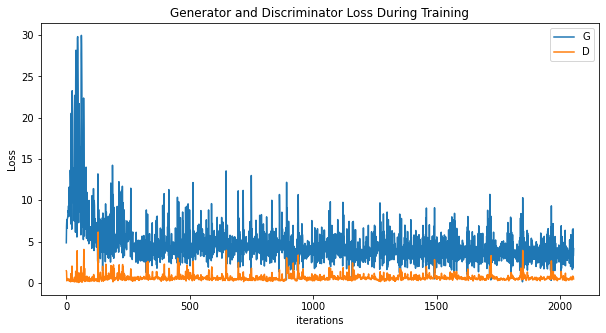

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

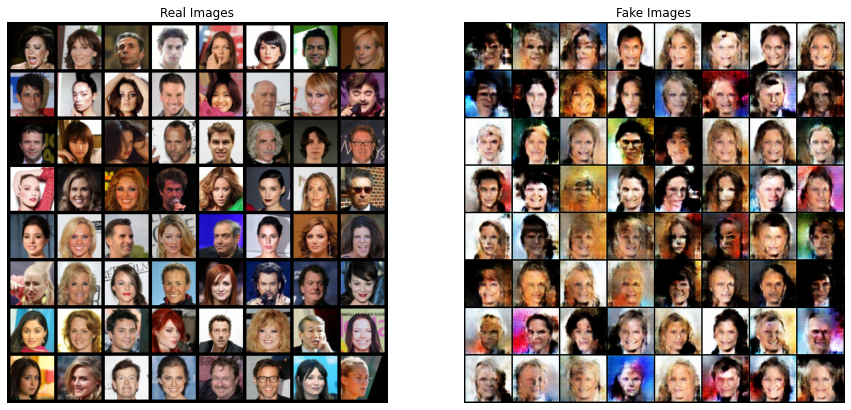

In [ ]:
# dataloaderから本物の画像を取得する
real_batch = next(iter(dataloader))

# 本物画像をプロット
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# 最後のエポックから偽物画像をプロットする
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()